In [1]:
import keras
from keras.layers import Dropout, Input, Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Reshape, BatchNormalization, UpSampling3D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from plotly.offline import iplot, init_notebook_mode
import h5py

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

import gc
import warnings
import time
import numpy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
from scipy.io import loadmat 
import pandas as pd
import seaborn as sns

init_notebook_mode(connected=True)

from spectral import *
import spectral.io.envi as envi

import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

In [2]:
HSI = envi.open('C:/Users/HP/Downloads/Data_Envi/Data_Envi/samson_1.img.hdr')
HSI = HSI.load()
HSI = np.array(HSI)
GT = labels = loadmat('C:/Users/HP/Desktop/samgt.mat')['A'].reshape(3,95,95)
GT = GT.T
print(HSI.shape)
print(GT.shape)

(95, 95, 156)
(95, 95, 3)


In [3]:
def plot_data(data):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.show()

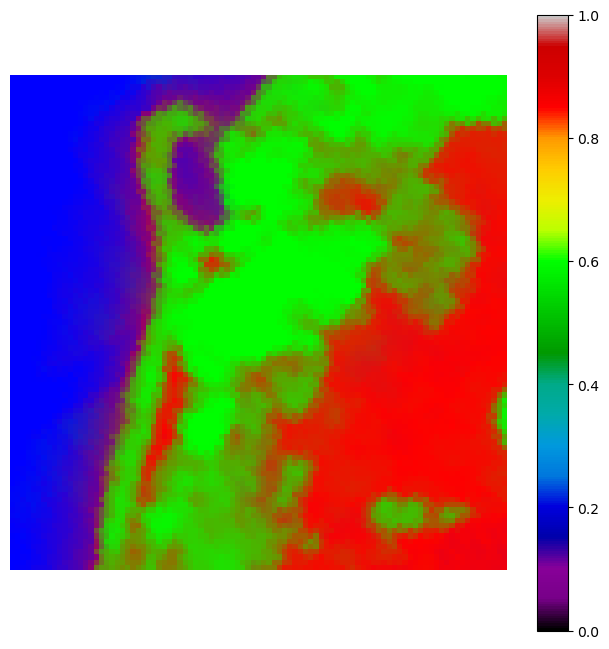

In [4]:
plot_data(GT)

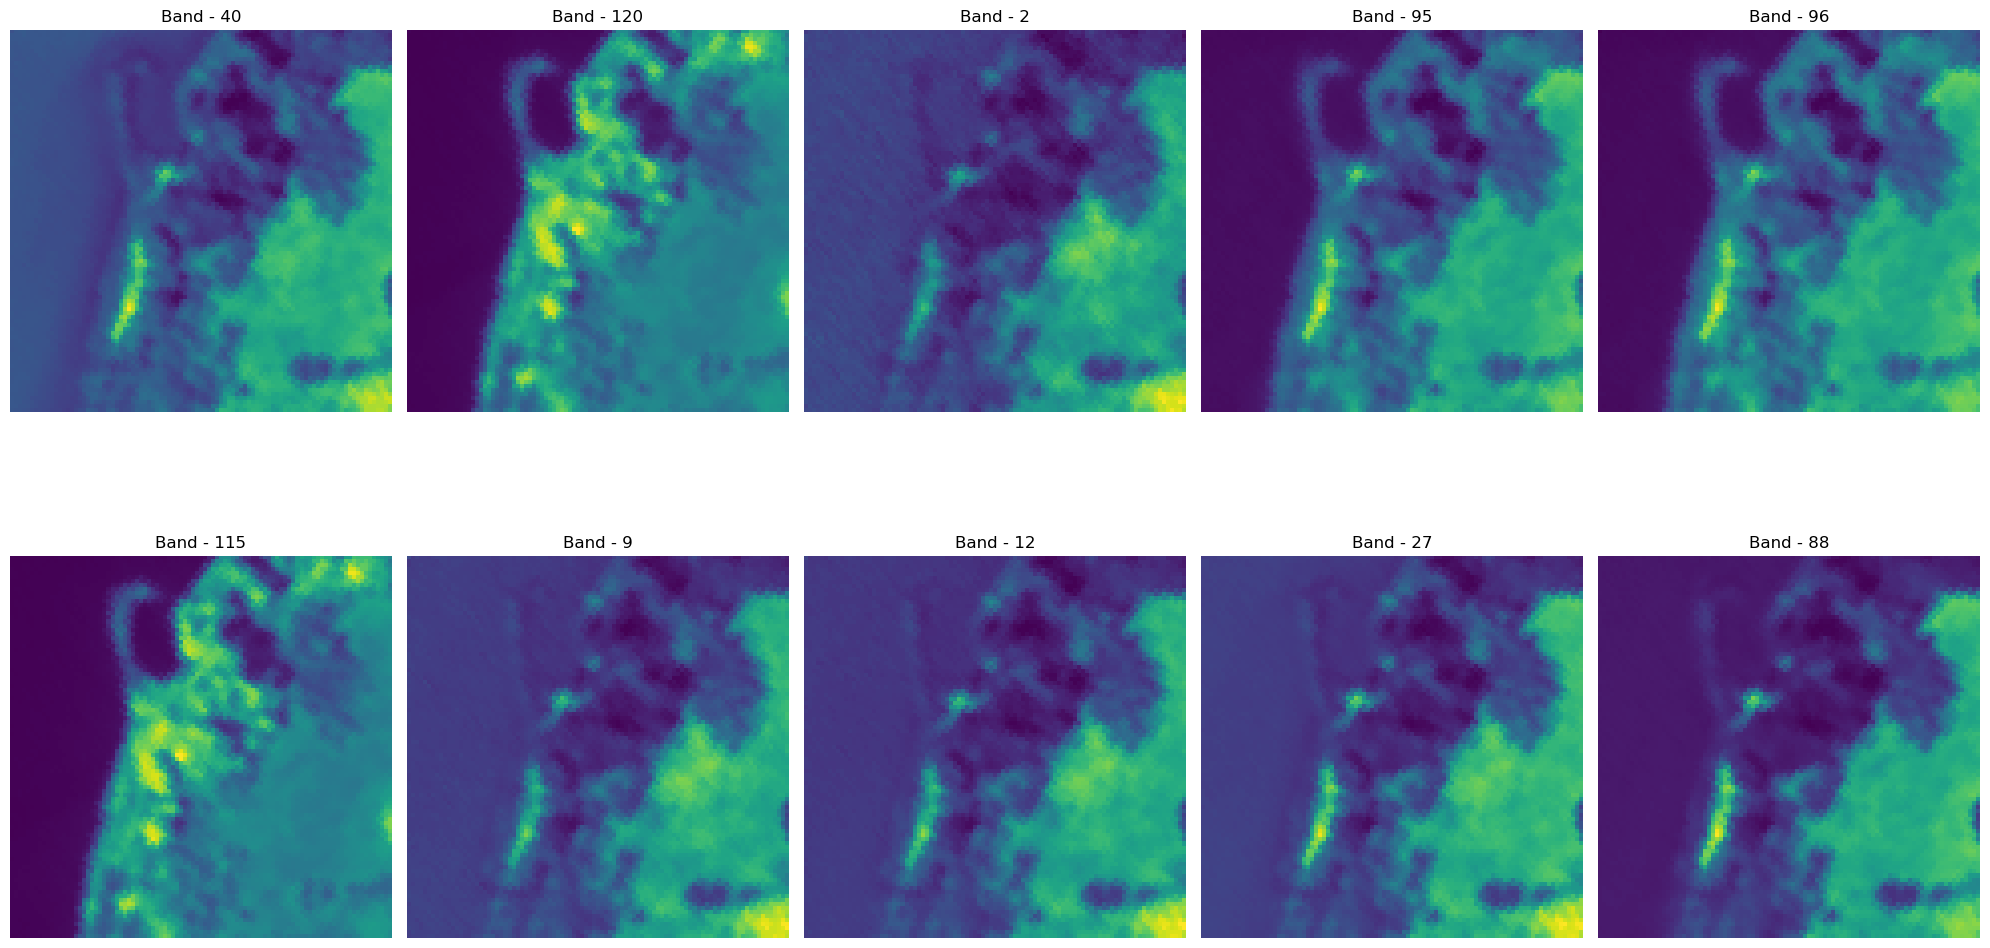

In [3]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
    for j in range(5):
        c = np.random.randint(156)
        ax[i][j].imshow(HSI[:, :, c])
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()

plt.show()

In [4]:
GT=GT.reshape(9025,3)
GT1 = np.zeros((9025,3))
GT_score= np.zeros((9025))
for i in range(0,9025,1):
    x = np.argmax(GT[i,:])
    GT_score[i] = x+1
    GT1[i,x] =1

In [5]:
GT=GT_score.reshape(95, 95)

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
HSI,pca = applyPCA(HSI,numComponents=6)
HSI.shape

(95, 95, 6)

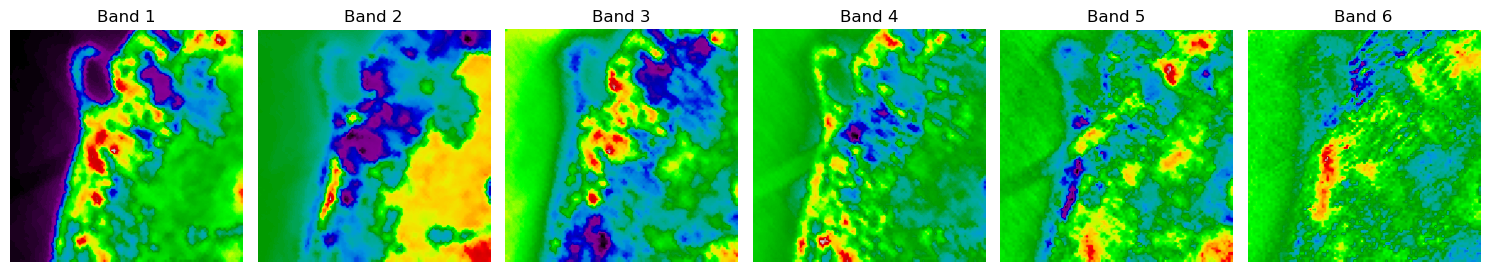

In [8]:
def visualize_bands(HSI):
    num_components = HSI.shape[2]
    fig, axs = plt.subplots(1, num_components, figsize=(15, 3))
    
    for i in range(num_components):
        band = HSI[:, :, i]
        axs[i].imshow(band, cmap='nipy_spectral')
        axs[i].set_title(f'Band {i+1}')
        axs[i].axis('off')
        
    
    plt.tight_layout()
    plt.show()
visualize_bands(HSI)

In [9]:
def ZeroPad(HSI, margin=2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

In [10]:
def HSICubes(HSI, GT, WinSize=3, removeZeroLabels = True):
    margin = int((WinSize - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin=margin)
    
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WinSize, WinSize, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
HSI, GT = HSICubes(HSI, GT, WinSize=3)
print(HSI.shape)
print(GT.shape)

(9025, 3, 3, 6)
(9025,)


In [12]:
def splitTrainTestSet(HSI, GT, TeRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=TeRatio, random_state=randomState, stratify=GT)
    return Tr, Te, TrC, TeC

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(HSI, GT, 0.70)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2707, 3, 3, 6), (6318, 3, 3, 6), (2707,), (6318,))

In [14]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.30)
Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((1894, 3, 3, 6), (813, 3, 3, 6), (1894,), (813,))

In [15]:
Xtrain = Xtrain.reshape(-1, 3, 3, 6, 1)
ytrain = np_utils.to_categorical(ytrain)
Xvalid = Xvalid.reshape(-1, 3, 3, 6, 1) 
yvalid = np_utils.to_categorical(yvalid) 
Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape

((1894, 3, 3, 6, 1), (1894, 3), (813, 3, 3, 6, 1), (813, 3))

In [16]:
from tensorflow.keras import layers

In [17]:
import tensorflow as tf

In [18]:
input_layer = Input((3, 3, 6, 1))

leaky_relu = layers.LeakyReLU(alpha=0.1)

conv_layer1 = Conv3D(filters=16, kernel_size=(1, 1, 1), activation=leaky_relu)(input_layer)
conv_layer2 = Conv3D(filters=32, kernel_size=(1, 1, 1), activation=leaky_relu)(conv_layer1)
conv_layer3 = Conv3D(filters=64, kernel_size=(1, 1, 1), activation=leaky_relu)(conv_layer2)
conv_layer4 = Conv3D(filters=128, kernel_size=(1, 1, 1), activation=leaky_relu)(conv_layer3)
conv_layer5 = Conv3D(filters=256, kernel_size=(1, 1, 1), activation=leaky_relu)(conv_layer4)

flatten_layer = Flatten()(conv_layer5)

dense_layer1 = Dense(units=128, activation=leaky_relu)(flatten_layer)
dense_layer1 = Dropout(0.5)(dense_layer1)
output_layer = Dense(units=3, activation='linear')(dense_layer1)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 3, 6, 1)]      0         
                                                                 
 conv3d (Conv3D)             (None, 3, 3, 6, 16)       32        
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 3, 6, 32)       544       
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 3, 6, 64)       2112      
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 3, 6, 128)      8320      
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 3, 6, 256)      33024     
                                                                 
 flatten (Flatten)           (None, 13824)             0     

In [19]:
adam = Adam(learning_rate=0.0001, decay=0.0001)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'cosine_similarity','accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [22]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, validation_data=(Xvalid, yvalid))

Epoch 1/100
8/8 [==============================] - 2s 120ms/step - loss: 0.1604 - mse: 0.1604 - mae: 0.2892 - cosine_similarity: 0.7571 - accuracy: 0.7698 - val_loss: 0.0611 - val_mse: 0.0611 - val_mae: 0.1710 - val_cosine_similarity: 0.9262 - val_accuracy: 0.9225
Epoch 2/100
8/8 [==============================] - 1s 97ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.1949 - cosine_similarity: 0.9233 - accuracy: 0.9340 - val_loss: 0.0448 - val_mse: 0.0448 - val_mae: 0.1358 - val_cosine_similarity: 0.9403 - val_accuracy: 0.9299
Epoch 3/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0544 - mse: 0.0544 - mae: 0.1679 - cosine_similarity: 0.9336 - accuracy: 0.9335 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.1230 - val_cosine_similarity: 0.9439 - val_accuracy: 0.9373
Epoch 4/100
8/8 [==============================] - 1s 97ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1572 - cosine_similarity: 0.9378 - accuracy: 0.9393 - val_loss: 0.0326 - val_mse: 0.0326 - val_mae: 0.111

In [24]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [25]:
Xtest = Xtest.reshape(-1, 3, 3, 6, 1)
ytest = np_utils.to_categorical(ytest)
Xtest.shape, ytest.shape

((6318, 3, 3, 6, 1), (6318, 3))

In [26]:
def reports(Te,TeC):
    start = time.time()
    Y_pred =  model.predict(Te)
    y_pred = np.argmax(Y_pred, axis=1)
    end = time.time()
    total = end - start
    target_names = ['Endmember1', 'Endmember2', 'Endmember3']
    classification = classification_report(np.argmax(TeC, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), y_pred)
    score = model.evaluate(Te, TeC, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, target_names, y_pred, total

In [27]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [28]:
classification,confusion,Test_loss,Test_accuracy,oa,each_acc,aa,kappa,target_names,y_pred,Time = reports(Xtest, ytest)
classification = str(classification)
confusion = str(confusion)
print(classification), print(Test_accuracy), print(oa), print(aa)

198/198 [==============================] - 1s 4ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0649 - cosine_similarity: 0.9776 - accuracy: 0.9756
              precision    recall  f1-score   support

  Endmember1       0.98      0.95      0.96      2111
  Endmember2       0.97      0.98      0.98      2566
  Endmember3       0.98      1.00      0.99      1641

    accuracy                           0.98      6318
   macro avg       0.98      0.98      0.98      6318
weighted avg       0.98      0.98      0.98      6318

1.6257703304290771
97.56251978474201
97.67619931128722


(None, None, None, None)

<Axes: xlabel='Predicted', ylabel='Actual'>

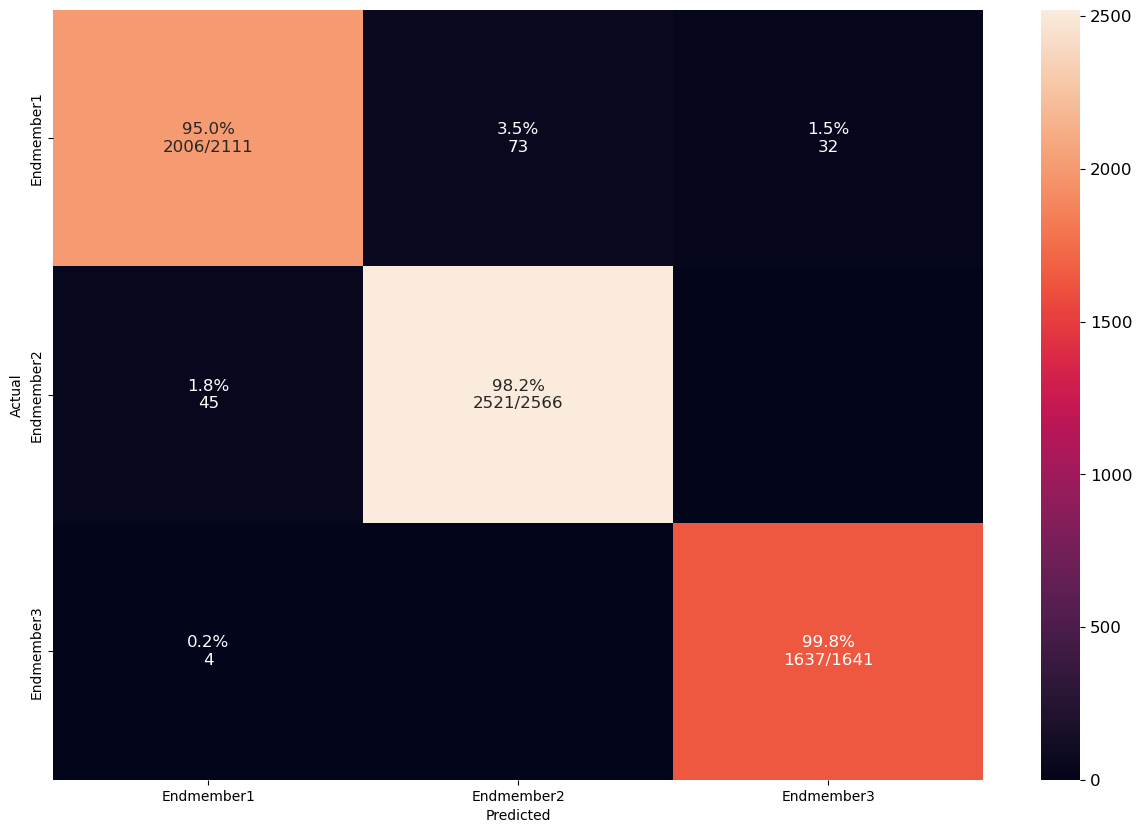

In [29]:
confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred, labels=np.unique(np.argmax(ytest, axis=1)))
cm_sum = np.sum(confusion, axis=1, keepdims=True)
cm_perc = confusion / cm_sum.astype(float) * 100
annot = np.empty_like(confusion).astype(str)
nrows, ncols = confusion.shape
for i in range(nrows):
    for j in range(ncols):
        c = confusion[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 12})
sns.heatmap(cm, annot=annot, fmt='', ax=ax)

In [30]:
confusion

array([[2006,   73,   32],
       [  45, 2521,    0],
       [   4,    0, 1637]], dtype=int64)

In [31]:
import numpy as np

def calculate_error(confusion_matrix):
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1] + confusion_matrix[2, 1]
    TN = confusion_matrix[0, 0] + confusion_matrix[0, 2] + confusion_matrix[1, 0] + confusion_matrix[1, 2] + confusion_matrix[2, 0] + confusion_matrix[2, 2]
    FN = confusion_matrix[1, 0] + confusion_matrix[1, 2]
    error = (FP + FN) / (TP + TN + FP + FN)
    return error

error = calculate_error(confusion)
print("Error:", error)

Error: 0.018544711614018546


In [32]:
Y_pred = model.predict(Xtest)
y_pred = np.argmax(Y_pred, axis=1)

198/198 [==============================] - 1s 3ms/step


In [33]:
HSI = envi.open('C:/Users/HP/Downloads/Data_Envi/Data_Envi/samson_1.img.hdr')
HSI = HSI.load()
HSI = np.array(HSI)
GT = labels = loadmat('C:/Users/HP/Desktop/samgt.mat')['A'].reshape(3,95,95)
GT = GT.T
print(HSI.shape)
print(GT.shape)

GTU=GT.reshape(9025,3)
GT1 = np.zeros((9025,3))
GT_score= np.zeros((9025))
for i in range(0,9025,1):
    x = np.argmax(GTU[i,:])
    GT_score[i] = x+1
    GT1[i,x] =1
    
GT_score=GT_score.reshape(95, 95)

(95, 95, 156)
(95, 95, 3)


In [34]:
def Patch(data,height_index,width_index,label_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    label_slice = slice(label_index, label_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [35]:
height = GT.shape[0]
width = GT.shape[1]
label =GT.shape[2]
PATCH_SIZE = 3

In [36]:
HSI,pca = applyPCA(HSI, numComponents=6)
HSI.shape
HSI = ZeroPad(HSI, 3//2)

In [37]:
outputs = np.zeros((height, width, label))

for i in range(height):
    for j in range(width):
        image_patch = Patch(HSI, i, j, label)
        X_test_image = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')  
        prediction = model.predict(X_test_image)
        outputs[i, j, :] = prediction       

1/1 [==============================] - 0s 25ms/step


In [38]:
outputs = np.abs(outputs) 
outputs /= np.sum(outputs, axis=-1, keepdims=True)

In [39]:
outputs.shape

(95, 95, 3)

In [40]:
def plot_data(data):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.show()

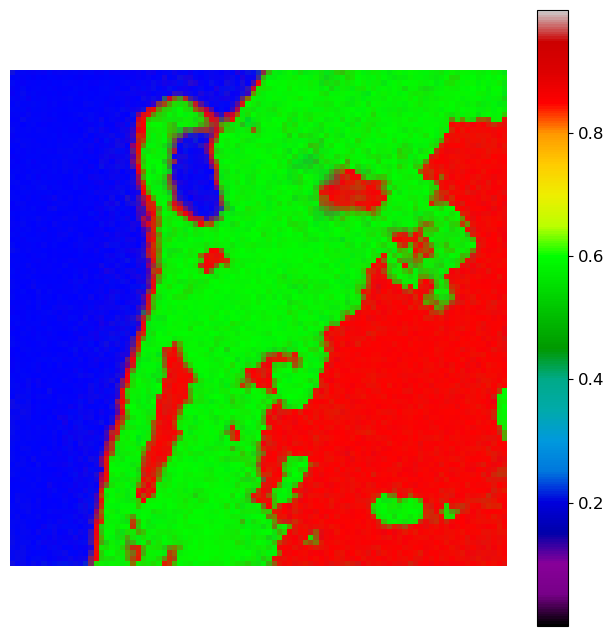

In [41]:
plot_data(outputs)

In [42]:
np.set_printoptions(suppress=True)

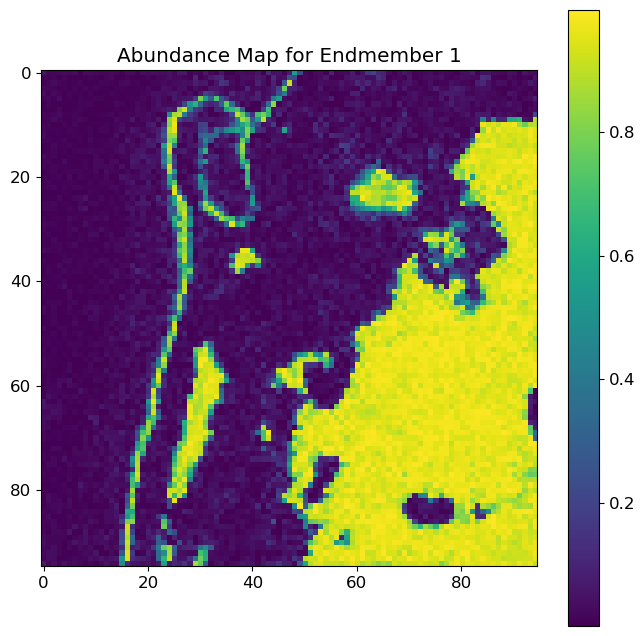

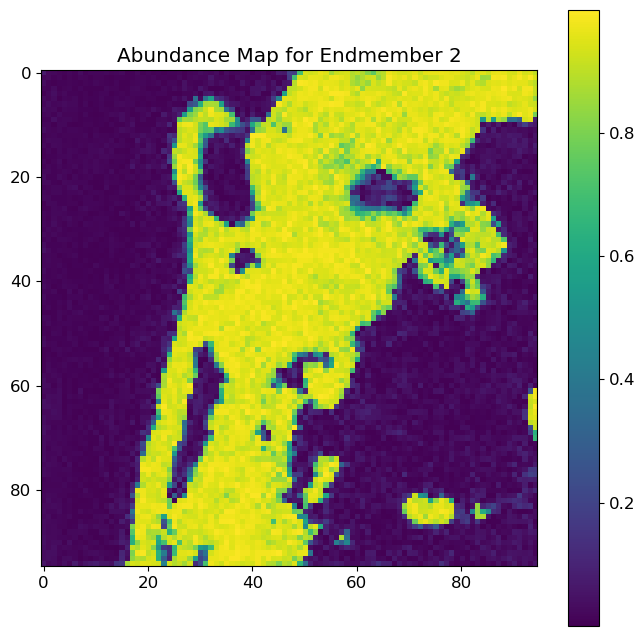

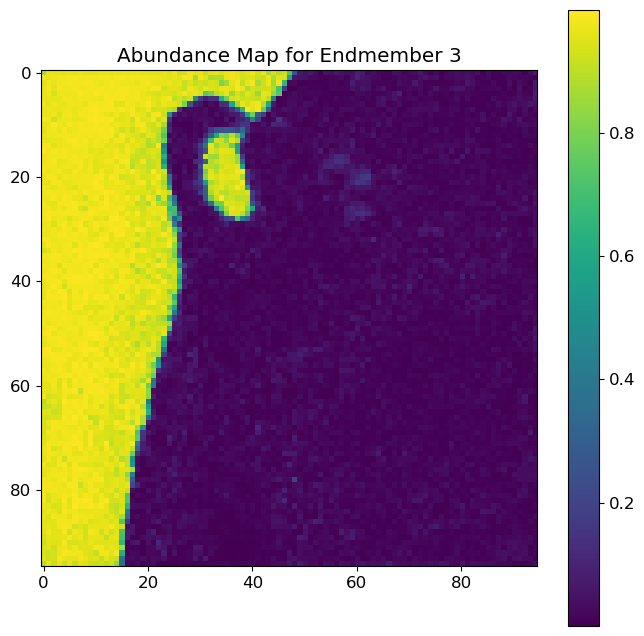

In [43]:
import matplotlib.pyplot as plt

for k in range(label):
    plt.figure(figsize=(8, 8))
    plt.title(f"Abundance Map for Endmember {k+1}")
    plt.imshow(outputs[:, :, k])
    plt.colorbar()
    plt.show()

In [44]:
import math

In [45]:
MSE = np.square(np.subtract(GT,outputs)).mean()

In [46]:
print(MSE)

0.019675916041718974


In [47]:
outputs

array([[[0.06541826, 0.07237325, 0.86220849],
        [0.01361546, 0.02555007, 0.96083447],
        [0.01521027, 0.02271791, 0.96207182],
        ...,
        [0.0574052 , 0.93662613, 0.00596867],
        [0.02761966, 0.94505778, 0.02732256],
        [0.02468295, 0.90704397, 0.06827308]],

       [[0.00291841, 0.01726292, 0.97981866],
        [0.00768933, 0.02447825, 0.96783242],
        [0.01826455, 0.00800442, 0.97373103],
        ...,
        [0.01839481, 0.96001311, 0.02159208],
        [0.00057997, 0.99098279, 0.00843724],
        [0.05473188, 0.9416193 , 0.00364883]],

       [[0.00964992, 0.03330655, 0.95704354],
        [0.01431999, 0.00828865, 0.97739136],
        [0.03062457, 0.00186909, 0.96750634],
        ...,
        [0.02516229, 0.95782944, 0.01700827],
        [0.06774283, 0.928056  , 0.00420117],
        [0.04159542, 0.89413794, 0.06426664]],

       ...,

       [[0.02067111, 0.03491774, 0.94441114],
        [0.03595418, 0.03520914, 0.92883668],
        [0.03376207, 0

In [48]:
GT

array([[[0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        ...,
        [0.        , 1.        , 0.        ],
        [0.02113788, 0.97886212, 0.        ],
        [0.01201712, 0.98798288, 0.        ]],

       [[0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        ...,
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.00809929, 0.99190071, 0.        ]],

       [[0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.        ],
        ...,
        [0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.00344306, 0.99655694, 0.        ]],

       ...,

       [[0.        , 0.        , 1.        ],
        [0.00299577, 0.        , 0.99700423],
        [0.01676455, 0